In [667]:
# Modul Dasar
import numpy as np               # Operasi matematika dan array
import pandas as pd              # Struktur data tabular (DataFrame)
import matplotlib.pyplot as plt  # Visualisasi data
import seaborn as sns            # Visualisasi data tambahan

# Statistik dan Machine Learning
from scipy import stats          # Statistik
from sklearn import datasets     # Datasets untuk machine learning
from sklearn.model_selection import train_test_split  # Pembagian data train-test
from sklearn.preprocessing import StandardScaler     # Normalisasi data
from sklearn.linear_model import LinearRegression    # Regresi linear
from sklearn.tree import DecisionTreeClassifier      # Klasifikasi menggunakan Decision Tree
from sklearn.cluster import KMeans                    # KMeans clustering

# Evaluasi Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Evaluasi performa model

# Visualisasi Machine Learning
from sklearn.tree import plot_tree    # Visualisasi struktur Decision Tree
from sklearn.metrics import roc_curve, auc  # Kurva ROC dan AUC


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [668]:
import numpy as np
import tensorflow as tf

# Set seed for numpy
np.random.seed(42)

# Set seed for TensorFlow
tf.random.set_seed(42)


In [669]:
# data = pd.read_csv("../data/external/ihsg 14-12-22 till 22-04-24.csv")
data = pd.read_csv("../data/external/5 tahun.csv")
# sentiment = pd.read_csv("../data/processed/preprocces-data.csv")

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-23,6420.163086,6482.818848,6415.455078,6462.821777,6462.821777,105904400.0
1,2019-04-24,6460.265137,6472.527832,6433.972168,6447.884766,6447.884766,95981100.0
2,2019-04-25,6423.837891,6431.591797,6353.283203,6372.787109,6372.787109,95830800.0


In [670]:
# sentiment


# sentiment_mapping = {"positive": 0, "negative": 1, "neutral": 2}

# data['Sentiment'] = sentiment['sentiment'].map(sentiment_mapping)

In [671]:
data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-23,6420.163086,6482.818848,6415.455078,6462.821777,6462.821777,105904400.0
1,2019-04-24,6460.265137,6472.527832,6433.972168,6447.884766,6447.884766,95981100.0
2,2019-04-25,6423.837891,6431.591797,6353.283203,6372.787109,6372.787109,95830800.0


In [672]:
lengh_data = len(data)
split_ratio = 0.8
lengh_train = round(lengh_data * split_ratio)
lengh_validation = lengh_data -lengh_train

In [673]:
data = data.drop(["Volume"],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")

#hai widha

In [674]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True, var_names=None):
    """
    Mengubah data time series menjadi data supervised learning.

    Argumen:
    data: DataFrame, dataset time series yang akan diubah.
    n_in: int, jumlah timestep mundur sebagai input (X).
    n_out: int, jumlah timestep maju sebagai output (y).
    dropnan: bool, apakah akan menghapus baris dengan nilai NaN.
    var_names: list of str, nama variabel untuk setiap kolom.

    Returns:
    DataFrame yang sudah diubah menjadi format supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if var_names is None:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        else:
            names += [(var_names[j] + '(t-%d)' % i) for j in range(n_vars)]
    
    # Output sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            if var_names is None:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t)') for j in range(n_vars)]
        else:
            if var_names is None:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            else:
                names += [(var_names[j] + '(t+%d)' % i) for j in range(n_vars)]
    
    # Concatenate semua kolom
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Hapus baris dengan nilai NaN
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Contoh penggunaan:
# Misalkan 'data' adalah DataFrame yang berisi data time series
# dengan tiga fitur, dan kita ingin menggunakan 3 timestep mundur sebagai input
# dan 1 timestep maju sebagai output, dan nama variabel untuk setiap fitur adalah
# 'A', 'B', dan 'C'

var_names = data.columns
data_supervised = time_series_to_supervised(data, n_in=5, n_out=1, var_names=var_names)


In [675]:
train_data = data_supervised[:lengh_train]
validation_data = data_supervised[lengh_train:]

In [676]:
from sklearn.preprocessing import MinMaxScaler

# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi data train
scaled_train_data = scaler.fit_transform(train_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_train_data = pd.DataFrame(scaled_train_data, columns=train_data.columns)



In [677]:
y_train_scaled = scaled_train_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
# X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)"], axis=1)
X_train_scaled = scaled_train_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)",], axis=1)

In [678]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open(t-5)       977 non-null    float64
 1   High(t-5)       977 non-null    float64
 2   Low(t-5)        977 non-null    float64
 3   Close(t-5)      977 non-null    float64
 4   Adj Close(t-5)  977 non-null    float64
 5   Open(t-4)       977 non-null    float64
 6   High(t-4)       977 non-null    float64
 7   Low(t-4)        977 non-null    float64
 8   Close(t-4)      977 non-null    float64
 9   Adj Close(t-4)  977 non-null    float64
 10  Open(t-3)       977 non-null    float64
 11  High(t-3)       977 non-null    float64
 12  Low(t-3)        977 non-null    float64
 13  Close(t-3)      977 non-null    float64
 14  Adj Close(t-3)  977 non-null    float64
 15  Open(t-2)       977 non-null    float64
 16  High(t-2)       977 non-null    float64
 17  Low(t-2)        977 non-null    flo

In [679]:
y_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open(t)  977 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


In [680]:
# Misalnya, Anda memiliki 3 langkah waktu dan 5 fitur
timesteps = 4
features = 6
X_train = []
for i in range(timesteps):
    X_train.append(X_train_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_train = np.array(X_train)
X_train = X_train.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_train.shape)

(977, 4, 6)


In [681]:
scaled_val_data = scaler.fit_transform(validation_data)

# Konversi data yang telah dinormalisasi kembali ke dalam DataFrame
scaled_val_data = pd.DataFrame(scaled_val_data, columns=validation_data.columns)

y_val_scaled = scaled_val_data[["Open(t)"]]  # Ambil kolom Open(t) sebagai target
# X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)","Sentiment(t)"], axis=1)
X_val_scaled = scaled_val_data.drop(["Open(t)", "Close(t)", "High(t)", "Low(t)", "Adj Close(t)"], axis=1)


X_val = []
for i in range(timesteps):
    X_val.append(X_val_scaled.iloc[:, i*features:(i+1)*features].values)

# Ubah list menjadi array numpy
X_val = np.array(X_val)
X_val = X_val.transpose(1, 0, 2)
# Bentuknya menjadi (jumlah_sampel, timestep, feature)
print(X_val.shape)

(221, 4, 6)


In [682]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.optimizers import Nadam
from keras.layers import Activation

# Definisi model LSTM
model_lstm = Sequential()
# model_lstm.add(Bidirectional(LSTM(128, activation='swish', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_lstm.add(LSTM(128, activation='swish', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
# model_lstm.add(LSTM(128, activation='swish', return_sequences=False))
model_lstm.add(Dense(128,Activation('swish')))
model_lstm.add(Dense(1))

# Mengubah optimizer menjadi Nadam dengan learning rate 0.01
opt = Nadam(learning_rate=0.001)


# Menampilkan ringkasan model

In [683]:
from keras.metrics import RootMeanSquaredError
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Compile model dengan optimizer yang telah diperbarui dan loss function RMSE
model_lstm.compile(optimizer=opt, loss='mse', metrics=[RootMeanSquaredError()])



In [684]:
hist = model_lstm.fit(X_train, train_data['Open(t)'], 
                      epochs=100, 
                      batch_size=16,
                      validation_data=(X_val, validation_data['Open(t)']),
                      callbacks=[early_stopping])

Epoch 1/100
62/62 [==============================] - 4s 12ms/step - loss: 38039400.0000 - root_mean_squared_error: 6167.6089 - val_loss: 40431620.0000 - val_root_mean_squared_error: 6358.5864
Epoch 2/100
62/62 [==============================] - 0s 6ms/step - loss: 6621962.5000 - root_mean_squared_error: 2573.3174 - val_loss: 18787992.0000 - val_root_mean_squared_error: 4334.5117
Epoch 3/100
62/62 [==============================] - 0s 6ms/step - loss: 3252449.7500 - root_mean_squared_error: 1803.4550 - val_loss: 15868078.0000 - val_root_mean_squared_error: 3983.4756
Epoch 4/100
62/62 [==============================] - 0s 6ms/step - loss: 2130500.2500 - root_mean_squared_error: 1459.6233 - val_loss: 12400981.0000 - val_root_mean_squared_error: 3521.5027
Epoch 5/100
62/62 [==============================] - 0s 6ms/step - loss: 1328208.0000 - root_mean_squared_error: 1152.4791 - val_loss: 9301786.0000 - val_root_mean_squared_error: 3049.8831
Epoch 6/100
62/62 [==============================

In [685]:
model_lstm.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 128)               69120     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 dense_45 (Dense)            (None, 1)                 129       
                                                                 
Total params: 85761 (335.00 KB)
Trainable params: 85761 (335.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [686]:
y_pred = model_lstm.predict(X_train)

31/31 [==============================] - 0s 3ms/step


In [687]:
y_pred.shape

(977, 1)

In [688]:
y_pred.squeeze()

array([6728.196 , 6625.7583, 6575.1025, 6558.19  , 6551.8315, 6521.0815,
       6492.6997, 6449.849 , 6393.578 , 6323.4316, 6262.4614, 6212.2236,
       6204.6514, 6234.1   , 6273.2812, 6303.1343, 6580.6157, 6572.4883,
       6563.7065, 6552.265 , 6536.648 , 6547.67  , 6588.8374, 6620.0776,
       6614.2515, 6603.2026, 6606.111 , 6617.9346, 6633.854 , 6653.5103,
       6666.842 , 6670.099 , 6663.2363, 6659.9097, 6660.9414, 6658.212 ,
       6667.318 , 6689.873 , 6702.854 , 6699.6333, 6699.102 , 6699.148 ,
       6692.77  , 6699.019 , 6719.769 , 6730.1724, 6715.2354, 6693.829 ,
       6677.189 , 6650.9956, 6628.9033, 6639.2505, 6659.018 , 6653.168 ,
       6614.224 , 6532.776 , 6471.7847, 6479.722 , 6538.553 , 6568.7793,
       6562.936 , 6541.3237, 6536.618 , 6546.0474, 6560.943 , 6585.0967,
       6586.5425, 6565.855 , 6541.8423, 6528.5796, 6527.017 , 6545.0347,
       6574.9307, 6589.0503, 6600.3257, 6597.005 , 6578.0923, 6572.362 ,
       6587.9976, 6607.3467, 6618.547 , 6630.3667, 

In [689]:
train_data['Open(t)']

Date
2019-04-30    6437.975098
2019-05-09    6242.180176
2019-05-10    6203.103027
2019-05-13    6225.395020
2019-05-14    6081.401855
                 ...     
2023-05-10    6780.400879
2023-05-11    6811.904785
2023-05-12    6755.937988
2023-05-15    6708.463867
2023-05-16    6711.740234
Name: Open(t), Length: 977, dtype: float64

In [690]:
mse = np.mean((y_pred.squeeze() - train_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 112873.92649904647
RMSE: 335.9671509225961


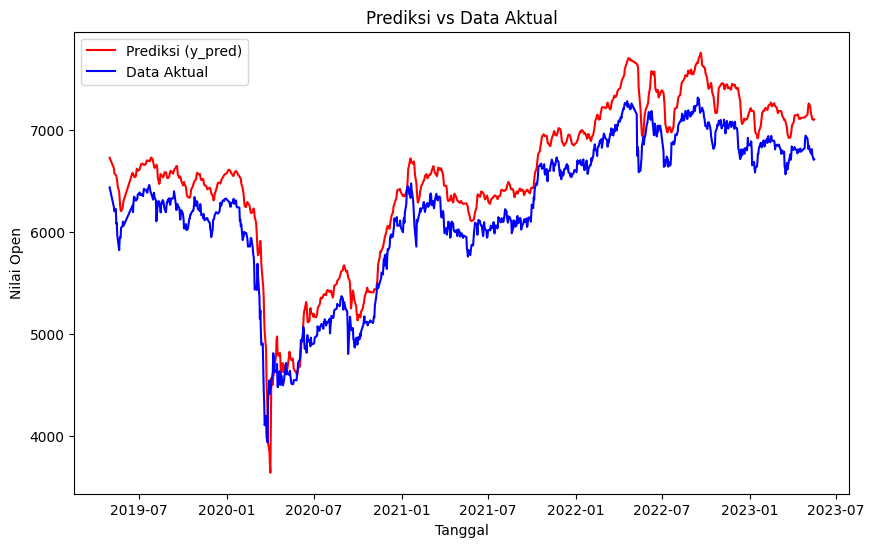

In [691]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, y_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(train_data.index, train_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [692]:
y_val_pred = model_lstm.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [693]:
y_val_pred.squeeze()

array([4860.0254, 4664.48  , 4402.0664, 4274.3354, 4169.711 , 4097.4883,
       4251.2144, 4447.2954, 4537.7183, 4507.3936, 4351.055 , 4163.0073,
       4015.7058, 3834.8713, 3613.9412, 3658.4575, 3635.0852, 3588.2527,
       3892.8208, 4178.562 , 4342.8687, 4392.9204, 4301.5815, 4272.637 ,
       4237.304 , 4148.932 , 3988.5093, 4101.727 , 3998.9526, 3821.2332,
       3916.6917, 4005.0063, 4171.488 , 4226.8086, 4362.4375, 4583.215 ,
       4532.8315, 4594.0273, 4854.0527, 5022.7847, 5089.7153, 5252.7886,
       5313.2466, 5224.941 , 5300.764 , 5398.108 , 5504.0796, 5563.2515,
       5584.159 , 5516.6714, 5463.6055, 5495.2485, 5422.9624, 5321.313 ,
       5381.5376, 5348.8164, 5365.9507, 5371.396 , 5373.667 , 5419.2363,
       5415.682 , 5447.887 , 5481.34  , 5417.9917, 5365.0674, 5391.1597,
       5501.3003, 5546.221 , 5508.7896, 5513.1987, 5620.3345, 5718.006 ,
       5765.124 , 5765.32  , 5824.8364, 5862.526 , 5849.3   , 5797.313 ,
       5703.649 , 5641.627 , 5666.225 , 5665.1553, 

In [694]:
validation_data['Open(t)']

Date
2023-05-17    6676.423828
2023-05-19    6663.113770
2023-05-22    6700.561035
2023-05-23    6729.646973
2023-05-24    6736.684082
                 ...     
2024-04-17    7199.830078
2024-04-18    7151.737793
2024-04-19    7131.455078
2024-04-22    7099.517090
2024-04-23    7102.903809
Name: Open(t), Length: 221, dtype: float64

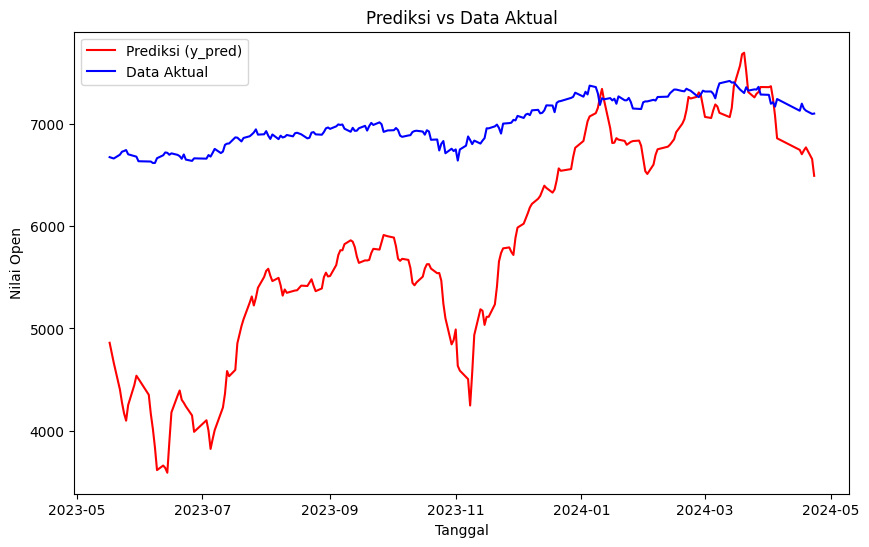

In [695]:
import matplotlib.pyplot as plt

# Plot hasil prediksi (y_pred) dan data aktual (train_data['Open(t)'])
plt.figure(figsize=(10, 6))
plt.plot(validation_data.index, y_val_pred.squeeze(), label='Prediksi (y_pred)', color='red')
plt.plot(validation_data.index, validation_data['Open(t)'], label='Data Aktual', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Nilai Open')
plt.title('Prediksi vs Data Aktual')
plt.legend()
plt.show()


In [696]:
mse = np.mean((y_val_pred.squeeze() - validation_data['Open(t)'])**2)

# Menghitung Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)

MSE: 2166742.4029045827
RMSE: 1471.9858704840149
